<a href="https://colab.research.google.com/github/sstoyanchev/fastai-class/blob/master/fastai_classify_kaggle_artists.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!curl https://course.fast.ai/setup/colab | bash
from fastai.vision import *
from fastai.metrics import error_rate

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   321  100   321    0     0   1158      0 --:--:-- --:--:-- --:--:--  1158
Updating fastai...
Done.


# Lesson 1 - Kaggle art dataset

> Indented block



In [4]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [6]:
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

100% 2.16G/2.16G [00:42<00:00, 82.4MB/s]
100% 2.16G/2.16G [00:42<00:00, 54.2MB/s]


In [7]:
!unzip '/content/best-artworks-of-all-time.zip'

Archive:  /content/best-artworks-of-all-time.zip
  inflating: images.zip              
  inflating: artists.csv             
  inflating: resized.zip             


In [8]:
!unzip '/content/resized.zip'

Archive:  /content/resized.zip
   creating: resized/
  inflating: resized/Marc_Chagall_136.jpg  
  inflating: resized/William_Turner_56.jpg  
  inflating: resized/William_Turner_57.jpg  
  inflating: resized/William_Turner_58.jpg  
  inflating: resized/William_Turner_59.jpg  
  inflating: resized/William_Turner_6.jpg  
  inflating: resized/William_Turner_60.jpg  
  inflating: resized/William_Turner_61.jpg  
  inflating: resized/William_Turner_62.jpg  
  inflating: resized/William_Turner_63.jpg  
  inflating: resized/William_Turner_64.jpg  
  inflating: resized/William_Turner_65.jpg  
  inflating: resized/William_Turner_66.jpg  
  inflating: resized/William_Turner_7.jpg  
  inflating: resized/William_Turner_8.jpg  
  inflating: resized/William_Turner_9.jpg  
  inflating: resized/Albrecht_Dürer_63.jpg  
  inflating: resized/Albrecht_Dürer_64.jpg  
  inflating: resized/Albrecht_Dürer_65.jpg  
  inflating: resized/Albrecht_Dürer_66.jpg  
  inflating: resized/Albrecht_Dürer_67.jpg  
  

In [0]:
import pandas as pd
df = pd.read_csv('/content/artists.csv', header=0, sep=',', quotechar='"')

In [75]:
df.paintings.mean(), len(df)

(168.92, 50)

In [74]:
df.head()

(   id  ... paintings
 0   0  ...       193
 1   1  ...        88
 2   2  ...        70
 3   3  ...        73
 4   4  ...       194
 
 [5 rows x 8 columns], 50)

In [11]:
len(df), df.paintings.mean()

(50, 168.92)

## Read images from the directory

In [0]:
path_img = '/content/resized'
fnames = get_image_files(path_img)

In [13]:
len(fnames)

8355

In [14]:
fnames[:5]

[PosixPath('/content/resized/Paul_Gauguin_296.jpg'),
 PosixPath('/content/resized/Salvador_Dali_105.jpg'),
 PosixPath('/content/resized/Vincent_van_Gogh_720.jpg'),
 PosixPath('/content/resized/Francisco_Goya_184.jpg'),
 PosixPath('/content/resized/Rene_Magritte_186.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=64
                                  ).normalize(imagenet_stats)

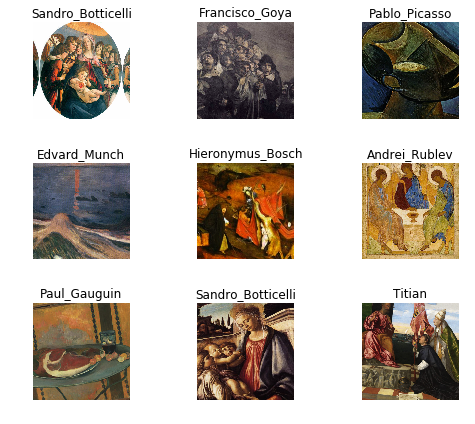

In [76]:
data.show_batch(rows=3, figsize=(7,6))

In [19]:
print(data.classes)
len(data.classes),data.c

['Albrecht_Dürer', 'Alfred_Sisley', 'Amedeo_Modigliani', 'Andrei_Rublev', 'Andy_Warhol', 'Camille_Pissarro', 'Caravaggio', 'Claude_Monet', 'Diego_Rivera', 'Diego_Velazquez', 'Edgar_Degas', 'Edouard_Manet', 'Edvard_Munch', 'El_Greco', 'Eugene_Delacroix', 'Francisco_Goya', 'Frida_Kahlo', 'Georges_Seurat', 'Giotto_di_Bondone', 'Gustav_Klimt', 'Gustave_Courbet', 'Henri_Matisse', 'Henri_Rousseau', 'Henri_de_Toulouse-Lautrec', 'Hieronymus_Bosch', 'Jackson_Pollock', 'Jan_van_Eyck', 'Joan_Miro', 'Kazimir_Malevich', 'Leonardo_da_Vinci', 'Marc_Chagall', 'Michelangelo', 'Mikhail_Vrubel', 'Pablo_Picasso', 'Paul_Cezanne', 'Paul_Gauguin', 'Paul_Klee', 'Peter_Paul_Rubens', 'Pierre-Auguste_Renoir', 'Piet_Mondrian', 'Pieter_Bruegel', 'Raphael', 'Rembrandt', 'Rene_Magritte', 'Salvador_Dali', 'Sandro_Botticelli', 'Titian', 'Vasiliy_Kandinskiy', 'Vincent_van_Gogh', 'William_Turner']


(50, 50)

## Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

In [29]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 141537382.02it/s]


In [30]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [31]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.916727,1.822731,0.487133,02:35
1,1.876727,1.398586,0.392579,02:32
2,1.472210,1.244497,0.338719,02:34
3,1.237624,1.213438,0.338719,02:33


In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [34]:
help(interp.plot_top_losses)

Help on method _cl_int_plot_top_losses in module fastai.vision.learner:

_cl_int_plot_top_losses(k, largest=True, figsize=(12, 12), heatmap:bool=True, heatmap_thresh:int=16, return_fig:bool=None) -> Union[matplotlib.figure.Figure, NoneType] method of fastai.train.ClassificationInterpretation instance
    Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class.



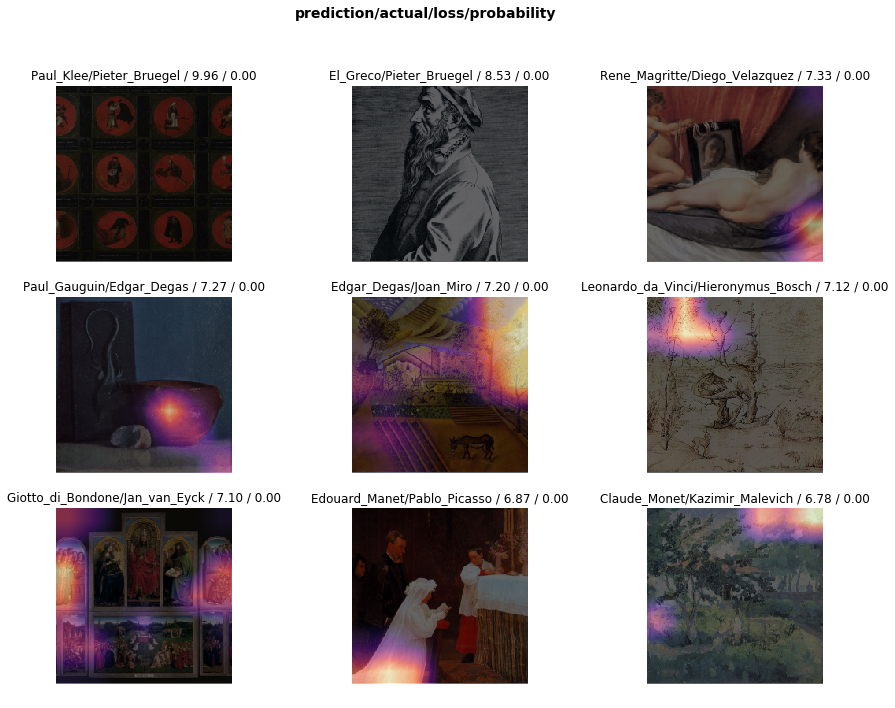

In [35]:
interp.plot_top_losses(9, figsize=(15,11))

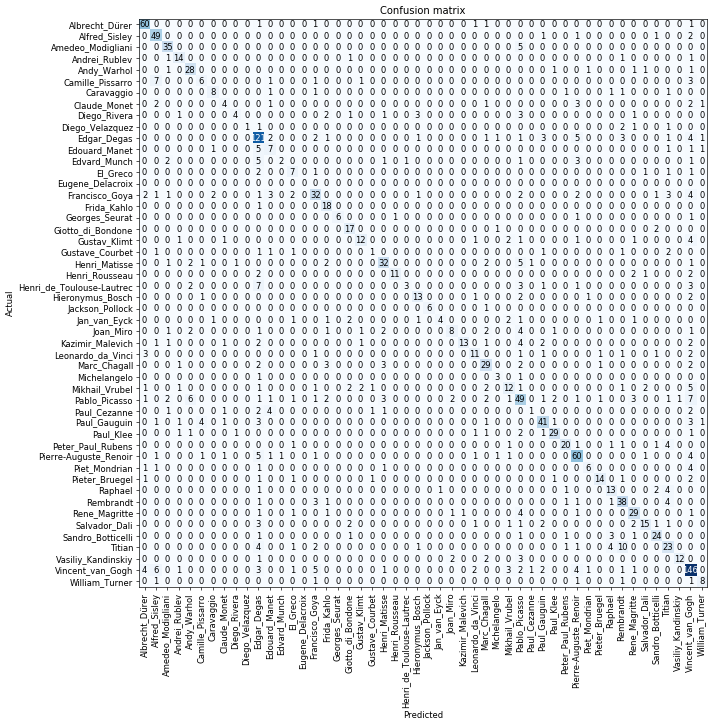

In [37]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [38]:
interp.most_confused(min_val=2)

[('Titian', 'Rembrandt', 10),
 ('Camille_Pissarro', 'Alfred_Sisley', 7),
 ('Henri_de_Toulouse-Lautrec', 'Edgar_Degas', 7),
 ('Pablo_Picasso', 'Vincent_van_Gogh', 7),
 ('Pablo_Picasso', 'Andy_Warhol', 6),
 ('Vincent_van_Gogh', 'Alfred_Sisley', 6),
 ('Amedeo_Modigliani', 'Pablo_Picasso', 5),
 ('Edgar_Degas', 'Pierre-Auguste_Renoir', 5),
 ('Edouard_Manet', 'Edgar_Degas', 5),
 ('Edvard_Munch', 'Edgar_Degas', 5),
 ('Henri_Matisse', 'Pablo_Picasso', 5),
 ('Mikhail_Vrubel', 'Vincent_van_Gogh', 5),
 ('Pierre-Auguste_Renoir', 'Edgar_Degas', 5),
 ('Vincent_van_Gogh', 'Francisco_Goya', 5),
 ('Edgar_Degas', 'Vincent_van_Gogh', 4),
 ('Francisco_Goya', 'Vincent_van_Gogh', 4),
 ('Gustav_Klimt', 'Vincent_van_Gogh', 4),
 ('Joan_Miro', 'Pablo_Picasso', 4),
 ('Kazimir_Malevich', 'Pablo_Picasso', 4),
 ('Paul_Cezanne', 'Edouard_Manet', 4),
 ('Paul_Gauguin', 'Camille_Pissarro', 4),
 ('Peter_Paul_Rubens', 'Titian', 4),
 ('Pierre-Auguste_Renoir', 'Vincent_van_Gogh', 4),
 ('Piet_Mondrian', 'Vincent_van_Gogh', 

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [0]:
#learn.load('stage-1');

In [39]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


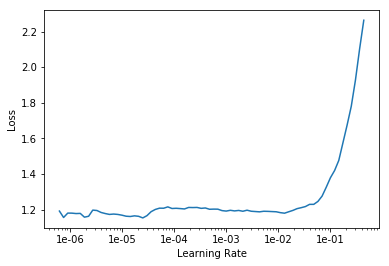

In [40]:
learn.recorder.plot()

In [41]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,2.014701,1.679553,0.438061,02:35
1,1.349225,0.990760,0.281867,02:37


# why is the error rate higher on the 0th epoch?
## would the learn plot be diferent after this re-training?


In [42]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


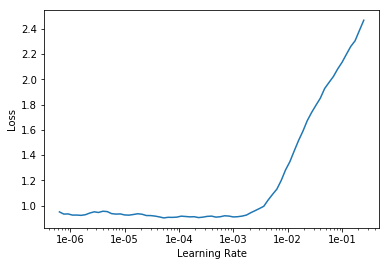

In [43]:
learn.recorder.plot()

In [0]:
learn.save('stage-2')

In [45]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-3))
learn.save('stage-3')

epoch,train_loss,valid_loss,error_rate,time
0,0.863212,0.871528,0.245362,02:33
1,0.746992,0.805851,0.226810,02:36


In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [47]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)


True

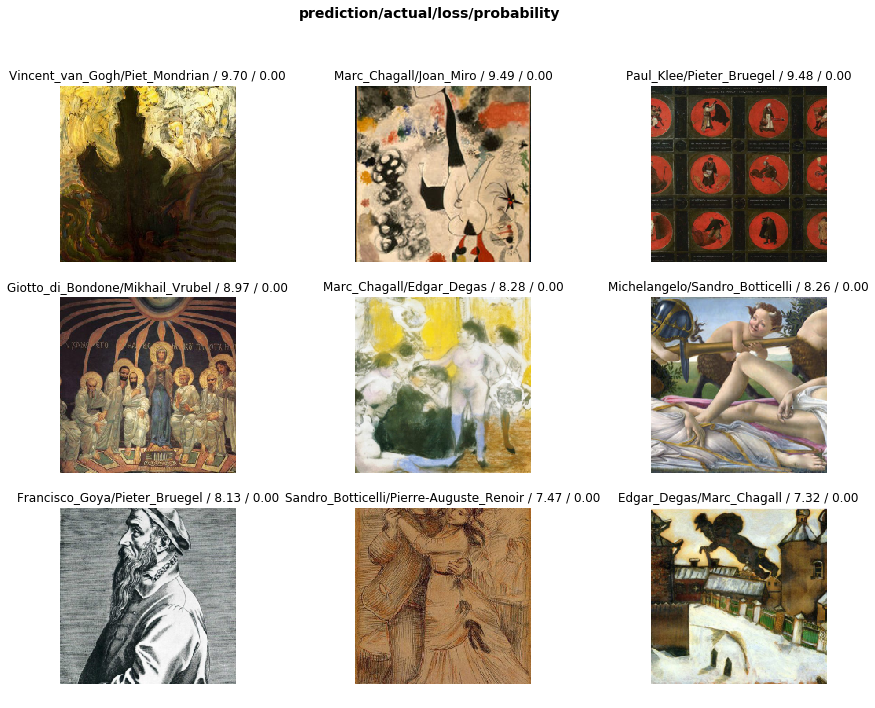

In [48]:

interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

In [50]:
%time learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 10.7 s, sys: 6.14 s, total: 16.8 s
Wall time: 1min 27s


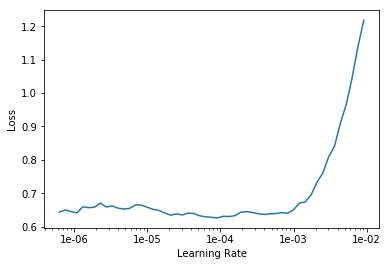

In [51]:
learn.recorder.plot()

In [52]:
learn.unfreeze()
%time learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.649783,0.788014,0.224417,02:38
1,0.580823,0.773972,0.215440,02:34


CPU times: user 34.7 s, sys: 18.6 s, total: 53.2 s
Wall time: 5min 12s


In [0]:
learn.save('stage-4')

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=32).normalize(imagenet_stats)

In [56]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 157534761.18it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


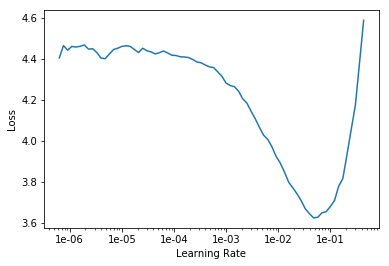

In [58]:
learn.lr_find()
learn.recorder.plot()

In [59]:
%time learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.093738,1.457537,0.384800,03:14
1,1.522022,1.146980,0.306403,03:10
2,1.226662,0.964590,0.278875,03:15
3,1.022027,0.831790,0.237582,03:11
4,0.850061,0.827214,0.234590,03:14
5,0.673015,0.742334,0.219031,03:14
6,0.518694,0.703829,0.200479,03:13
7,0.468309,0.711370,0.203471,03:18


CPU times: user 5min 49s, sys: 3min 20s, total: 9min 9s
Wall time: 25min 53s


In [0]:
learn.save('stage-1-50')

20 % error rate on classifying artist (that's without unfreezing..)

> Indented block



In [62]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.489812,0.694910,0.193297,03:28
1,0.438806,0.675201,0.193297,03:26
2,0.411154,0.663627,0.186715,03:26


If it doesn't, you can always go back to your previous model.

In [0]:
#learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [64]:
interp.most_confused(min_val=2)

[('Pablo_Picasso', 'Vincent_van_Gogh', 7),
 ('Raphael', 'Titian', 6),
 ('Claude_Monet', 'Alfred_Sisley', 5),
 ('Pablo_Picasso', 'Edgar_Degas', 5),
 ('Peter_Paul_Rubens', 'Titian', 4),
 ('Pieter_Bruegel', 'Vincent_van_Gogh', 4),
 ('Andy_Warhol', 'Joan_Miro', 3),
 ('Diego_Rivera', 'Pablo_Picasso', 3),
 ('Diego_Velazquez', 'Titian', 3),
 ('Edgar_Degas', 'Pablo_Picasso', 3),
 ('Francisco_Goya', 'Edgar_Degas', 3),
 ('Francisco_Goya', 'Leonardo_da_Vinci', 3),
 ('Francisco_Goya', 'Rembrandt', 3),
 ('Joan_Miro', 'Pablo_Picasso', 3),
 ('Kazimir_Malevich', 'Pablo_Picasso', 3),
 ('Mikhail_Vrubel', 'Vincent_van_Gogh', 3),
 ('Pablo_Picasso', 'Paul_Klee', 3),
 ('Paul_Gauguin', 'Alfred_Sisley', 3),
 ('Piet_Mondrian', 'Vincent_van_Gogh', 3),
 ('Raphael', 'Sandro_Botticelli', 3),
 ('Titian', 'Raphael', 3),
 ('Claude_Monet', 'Pierre-Auguste_Renoir', 2),
 ('Diego_Rivera', 'Hieronymus_Bosch', 2),
 ('Diego_Velazquez', 'Eugene_Delacroix', 2),
 ('Edgar_Degas', 'Pierre-Auguste_Renoir', 2),
 ('Edouard_Manet', 

In [0]:
learn.save('stage-2-50')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


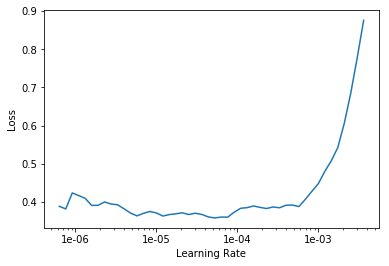

In [66]:
learn.lr_find()
learn.recorder.plot()

In [67]:
learn.unfreeze()
%time learn.fit_one_cycle(8, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.386075,0.662748,0.186116,03:24
1,0.395447,0.654517,0.186116,03:28
2,0.363803,0.619489,0.175943,03:28
3,0.355158,0.595160,0.163375,03:28
4,0.254400,0.585833,0.171753,03:29
5,0.217688,0.571480,0.156792,03:27
6,0.166049,0.570772,0.159186,03:28
7,0.151697,0.565362,0.154997,03:27


CPU times: user 7min 35s, sys: 4min 41s, total: 12min 17s
Wall time: 27min 43s


In [0]:
learn.save('stage-3-50')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()


In [72]:
help(interp.plot_top_losses)

Help on method _cl_int_plot_top_losses in module fastai.vision.learner:

_cl_int_plot_top_losses(k, largest=True, figsize=(12, 12), heatmap:bool=True, heatmap_thresh:int=16, return_fig:bool=None) -> Union[matplotlib.figure.Figure, NoneType] method of fastai.train.ClassificationInterpretation instance
    Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class.



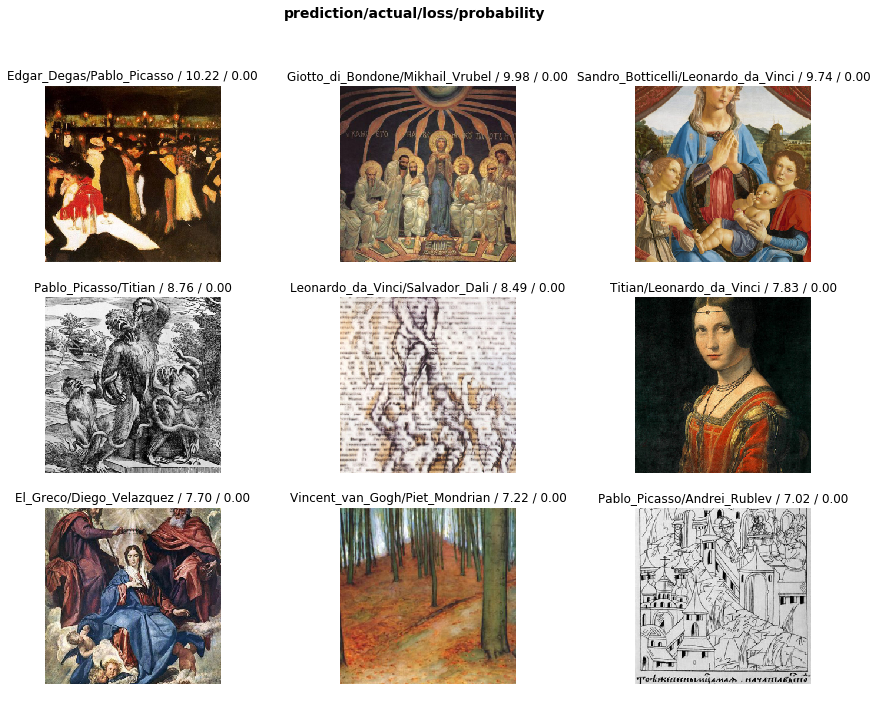

In [71]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)